In [139]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [140]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1


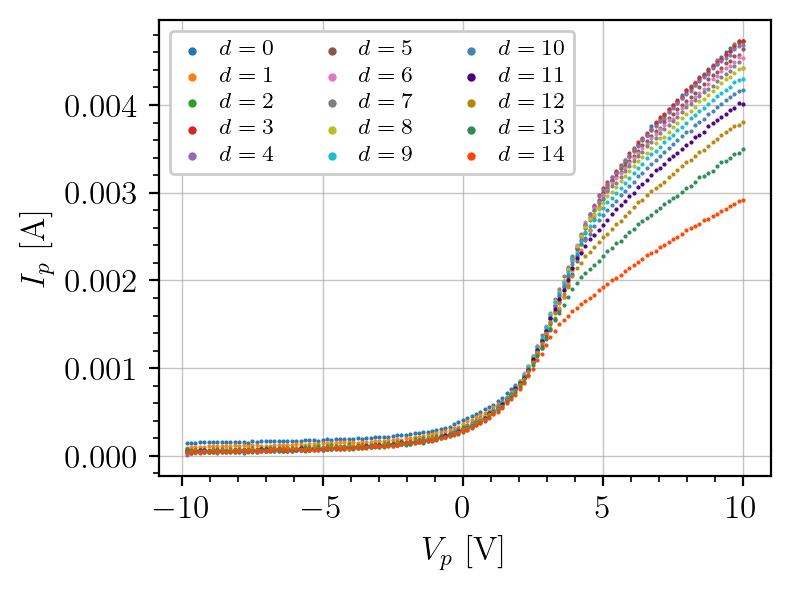

In [141]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
for run in range(8,23):
    p, d, G, A, f, I_chauffage, V_polarisation = np.loadtxt(f'../data/position/run{run}.tsv', delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    V_in, V_out, *_ = np.loadtxt(f'../data/position/run{run}.tsv', delimiter='\t', skiprows=2, unpack=True)
    I_out = V_out / (10 * G)
    values, counts = np.unique_counts(V_in)

    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    plt.scatter(V_in_combined, (I_out_combined), label=f"$d = {run - 8}$")
    idx = I_out_combined < 0
    # plt.scatter(V_in_combined[idx], I_out_combined[idx])
    plt.legend(ncols=3, fontsize=8, markerscale=4)

## Find V_{sp}, ln(I_{es})

5.38+/-0.13 0.00336+/-0.00007


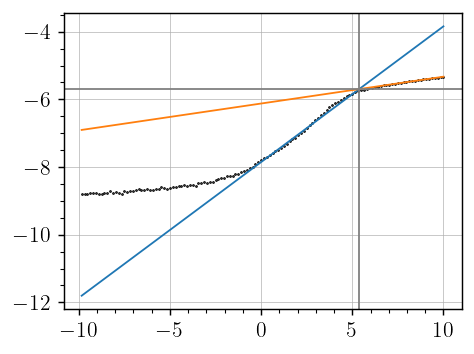

T_e = (2.89±0.05)×10⁴, INCOHERENT: T = (3.99±0.07)×10⁻¹⁹, n_e = (2.52±0.05)×10¹⁶
4.52+/-0.08 0.00309+/-0.00005


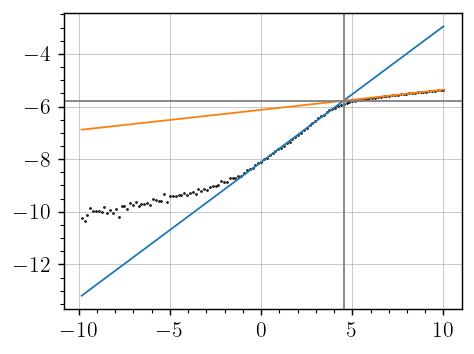

T_e = (2.25±0.03)×10⁴, INCOHERENT: T = (3.11±0.04)×10⁻¹⁹, n_e = (2.62±0.04)×10¹⁶
4.26+/-0.07 0.00277+/-0.00004


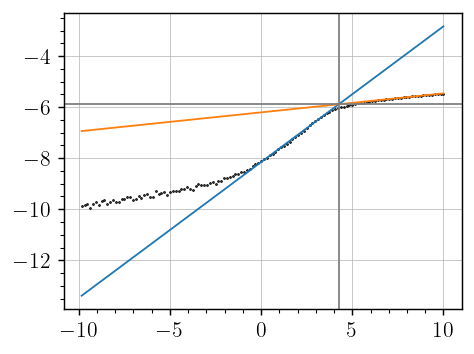

T_e = (2.18±0.03)×10⁴, INCOHERENT: T = (3.01±0.04)×10⁻¹⁹, n_e = (2.40±0.04)×10¹⁶


In [142]:
for run in range(8,23, 5): #23
    p, d, G, A, f, I_chauffage, V_polarisation = np.loadtxt(f'../data/position/run{run}.tsv', delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    V_in, V_out, *_ = np.loadtxt(f'../data/position/run{run}.tsv', delimiter='\t', skiprows=2, unpack=True)
    I_out = V_out / (10 * G)
    values, counts = np.unique_counts(V_in)

    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    idx_B = np.logical_and(0 < V_in_combined, V_in_combined < 3)
    idx_C = V_in_combined > 6

    coefsB, covB = np.polyfit(V_in_combined[idx_B], np.log(I_out_combined[idx_B]), 1, cov=True)
    coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
    fitfuncB = np.poly1d(coefsB)
    coefsC, covC = np.polyfit(V_in_combined[idx_C], np.log(I_out_combined[idx_C]), 1, cov=True)
    coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
    fitfuncC = np.poly1d(coefsC)

    plt.scatter(V_in_combined, np.log(I_out_combined), c='k')
    x = np.linspace(V_in_combined[0], V_in_combined[-1])
    plt.plot(x, fitfuncB(x))
    plt.plot(x, fitfuncC(x))

    V_sp_intersect = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
    I_sp_intersect = umath.exp(coefs_errB[0] * V_sp_intersect + coefs_errB[1])
    print(V_sp_intersect, I_sp_intersect)
    plt.axvline(V_sp_intersect.n)
    plt.axhline(umath.log(I_sp_intersect).n)

    T_e = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT  # why not???? * ELEMENTARY_CHARGE
    T = T_e * BOLTZMANN_CONSTANT

    n_e = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT * T_e)) * I_sp_intersect
    plt.show()
    print(f"{T_e = :.1ueP}, INCOHERENT: {T = :.1ueP}, {n_e = :.1ueP}")